In [357]:
%pip install ta

Note: you may need to restart the kernel to use updated packages.


In [358]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
import getFamaFrenchFactors as gff
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Define the ticker symbol for Tesla
ticker = 'TSLA'

# Define the start and end dates for the data
start_date = '2019-01-01'
end_date = '2022-01-01'

# Download the data from Yahoo Finance
tsla = yf.download(ticker, start=start_date, end=end_date)


# Import ADS_INDEX
from datetime import datetime
date_parser = lambda x: datetime.strptime(x, '%Y:%m:%d')
ads_data = pd.read_excel("ads_index_010622.xlsx", parse_dates=['Date'], date_parser=date_parser)
new_ads_data = ads_data[['Date', 'ADS_INDEX_010622']].set_index('Date')

# Calculate OBV
tsla['daily_return'] = tsla['Adj Close'].pct_change()
tsla['direction'] = np.where(tsla['daily_return'] >= 0, 1, -1)
tsla['direction'][0] = 0
tsla['vol_adjusted'] = tsla['Volume'] * tsla['direction']
tsla['OBV'] = tsla['vol_adjusted'].cumsum()


sp500 = yf.download('^GSPC', start=start_date, end=end_date)
aapl = yf.download('AAPL', start=start_date, end=end_date)
amzn = yf.download('AMZN', start=start_date, end=end_date)
goog = yf.download('GOOG', start=start_date, end=end_date)
cma = yf.download('CMA', start=start_date, end=end_date)
btc = yf.download('BTC-USD', start=start_date, end=end_date)
eth = yf.download('ETH-USD', start=start_date, end=end_date)
xrp = yf.download('XRP-USD', start=start_date, end=end_date)
ltc = yf.download('LTC-USD', start=start_date, end=end_date)
ada = yf.download('ADA-USD', start=start_date, end=end_date)
vix = yf.download('^VIX', start=start_date, end=end_date)

# Calculate additional features
tsla['mom_5_20'] = (tsla['Close'] / tsla['Close'].shift(5)) - 1
tsla['mom_20_100'] = (tsla['Close'] / tsla['Close'].shift(20)) - 1
tsla['mom_60_200'] = (tsla['Close'] / tsla['Close'].shift(60)) - 1

bkcn_df = yf.download("BKCN", start_date, end_date)
shsz300_df = yf.download("000300.SS", start_date, end_date)
rsi_indicator = RSIIndicator(close=tsla['Adj Close'], window=14)
macd_indicator = MACD(close=tsla['Adj Close'])

tsla['rsi'] = rsi_indicator.rsi()
tsla['macd'] = macd_indicator.macd()

print(shsz300_df.head())
print(bkcn_df.head())

# Calculate Fama French 3 factors
ff_data = gff.famaFrench3Factor(frequency='m') 
ff_data.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff_data.set_index('Date',inplace=True)
ff_data = ff_data.resample('D').interpolate()




# Reset index and convert all dates to same timezones, so they become mergable
for x in [sp500,aapl,amzn,goog,tsla,cma,btc,eth,xrp,ltc,ada,ff_data,vix,new_ads_data,shsz300_df,bkcn_df]:
    x.reset_index(inplace=True)
    x['Date'] =  pd.to_datetime(x['Date']).dt.date

tsla = ff_data.merge(tsla,on='Date')
tsla = new_ads_data.merge(tsla,on='Date')
    
## CORRECTION - Need to merge FF data according to date here

df_regressor = pd.DataFrame({
    'SP_500_Adj_Close':sp500['Adj Close'].shift(1),
    'AAPL_Adj_Close':aapl['Adj Close'].shift(1),
    'AMZN_Adj_Close':amzn['Adj Close'].shift(1),
    'GOOG_Adj_Close':goog['Adj Close'].shift(1),
    'CMA_Adj_Close':cma['Adj Close'].shift(1),
    'BTC_Adj_Close':btc['Adj Close'].shift(1),
    'ETH_Adj_Close':eth['Adj Close'].shift(1),
    'XRP_Adj_Close':xrp['Adj Close'].shift(1),
    'LTC_Adj_Close':ltc['Adj Close'].shift(1),
    'ADA_Adj_Close':ada['Adj Close'].shift(1),
    'Fama_French_Mkt_RF':tsla['Mkt-RF'].shift(1),
    'Fama_French_SMB' : tsla['SMB'].shift(1),
    'Fama_French_HML' : tsla['HML'].shift(1),
    'OBV': tsla['OBV'].shift(1),
    'mom_5_20':  tsla['mom_5_20'].shift(1),
    'mom_20_100':  tsla['mom_20_100'].shift(1),
    'mom_60_200':  tsla['mom_60_200'].shift(1),
     'TSLA_CLOSE': tsla['Adj Close'],
    'VIX_IDX':vix['Adj Close'].shift(1),
    'avg_close_20_days_': tsla['Adj Close'].rolling(window=20).mean().shift(1),
    'avg_Close_50_days':tsla['Adj Close'].rolling(window=50).mean().shift(1),
    'ADS_INDEX': tsla['ADS_INDEX_010622'].shift(1),
#     'bkcn_Adj_Close':bkcn_df['Adj Close'].shift(1),
    'shsz300_df':shsz300_df['Adj Close'].shift(1),
    
    'TSLA_RSI': tsla['rsi'].shift(1),
    'TSLA_MACD':tsla['macd'].shift(1)
})





# Remove any rows with missing data
df_regressor.dropna(inplace=True)
print(df_regressor.head)
print(df_regressor.shape)


scaler = StandardScaler()
X = scaler.fit_transform(df_regressor)
# Split the data into features (X) and target (y)
y = df_regressor['TSLA_CLOSE']
df_regressor = df_regressor.drop(columns=['TSLA_CLOSE'],axis=1)
X = df_regressor
# Fit a decision tree model to the data
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X, y)

# Select the top 10 most important features
selector_Decision_Trees = SelectFromModel(tree, prefit=True, threshold=-np.inf, max_features=10)
selected_features = X.columns[selector_Decision_Trees.get_support()]

final_feature_set = set()
# Print the top 10 most important features
print('Top 10 most important features through Decision Trees:')
for feature in selected_features:
    print(feature)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/var/folders/2s/jbd9m2gj61n3fk0zl36lyp940000gn/T/ipykernel_7995/3582321801.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla['direction'][0] = 0



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BKCN: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
                                  Open         High          Low        Close  \
Date                

In [359]:
ridge = Ridge(alpha=0.1)
ridge.fit(X, y)

# Select the top 10 most important features
selector_RIDGE = SelectFromModel(ridge, prefit=True, threshold=-np.inf, max_features=10)
selected_features = X.columns[selector_RIDGE.get_support()]

# Print the top 10 most important features
print('Top 10 most important features (Ridge Regression):')
for feature in selected_features:
      print('-', feature)



Top 10 most important features (Ridge Regression):
- XRP_Adj_Close
- ADA_Adj_Close
- Fama_French_Mkt_RF
- Fama_French_HML
- mom_5_20
- mom_20_100
- mom_60_200
- avg_Close_50_days
- ADS_INDEX
- TSLA_MACD


/Users/abhinav-m/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.92989e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [360]:
# Fit a LassoLarsCV model to the data
lars = LassoLarsCV(cv=5).fit(X, y)

# Select the top 10 most important features
selector_LARS = SelectFromModel(lars, prefit=True, threshold=-np.inf, max_features=10)
selected_features_LARS = X.columns[selector_LARS.get_support()]

# Print the top 10 most important features
print('Top 10 most important features (LARS):')
for feature in selected_features_LARS:
      print('-', feature)

Top 10 most important features (LARS):
- AAPL_Adj_Close
- ADA_Adj_Close
- Fama_French_Mkt_RF
- Fama_French_SMB
- mom_5_20
- avg_close_20_days_
- ADS_INDEX
- shsz300_df
- TSLA_RSI
- TSLA_MACD


In [361]:
# Fit a RandomForest model to the data
rf = RandomForestRegressor(random_state=0, n_estimators=100).fit(X, y)

# Select the top 10 most important features
selector_RF = SelectFromModel(rf, prefit=True, threshold=-np.inf, max_features=10)
selected_features = X.columns[selector_RF.get_support()]
# selector.estimator.columns
# selector.threshold_

# Print the top 10 most important features
print('Top 10 most important features (RandomForest):')
for feature in selected_features:
    print('-', feature)

Top 10 most important features (RandomForest):
- AAPL_Adj_Close
- ADA_Adj_Close
- Fama_French_Mkt_RF
- Fama_French_HML
- mom_60_200
- VIX_IDX
- avg_Close_50_days
- ADS_INDEX
- TSLA_RSI
- TSLA_MACD


In [362]:
# Fit an XGBoost model to the data
xgb_model = xgb.XGBRegressor(random_state=0, n_estimators=100).fit(X, y)

# Select the top 10 most important features
selector_XGB = SelectFromModel(xgb_model, prefit=True, threshold=-np.inf, max_features=10)
selected_features = X.columns[selector_XGB.get_support()]

# Print the top 10 most important features
print('Top 10 most important features (XGBoost):')
for feature in selected_features:
    print('-', feature)

Top 10 most important features (XGBoost):
- BTC_Adj_Close
- ADA_Adj_Close
- Fama_French_Mkt_RF
- Fama_French_HML
- OBV
- mom_60_200
- VIX_IDX
- avg_close_20_days_
- ADS_INDEX
- TSLA_RSI


## Doubts
1. KDE Estimation - Enough just plotting the stock or actual KDE estimation
2. More feature suggestions / Momentum factors 

3. Class sample (0408) - Why fit linear regression after feature importance?? 

## Notes:
- Normalize data before KDE estimation
- Graphs / Subplots for different features - Price vs MacD etc

In [363]:

def plot_features_with_importance(title,selector,n=10):
    features_with_importance = sorted(list(zip(selector.estimator.feature_names_in_,selector.estimator.feature_importances_)),key = lambda x: x[1],reverse=True)
    features_with_importance = features_with_importance[:n]
    for f_name,f_imp in features_with_importance[:3]:
        final_feature_set.add(f_name)
    df = pd.DataFrame(data={"Feature Name":[x[0] for x in features_with_importance],"Coefficient / Importance":[x[1] for x in features_with_importance]},columns=["Feature Name","Coefficient / Importance"])
    plt.figure(figsize = ( 20 , 10 ))
    sns.barplot(x=df['Feature Name'],y=df["Coefficient / Importance"]) 
    # Set title for figure
    plt.title( title , size = 24 )
    # Display figure
    plt.show()





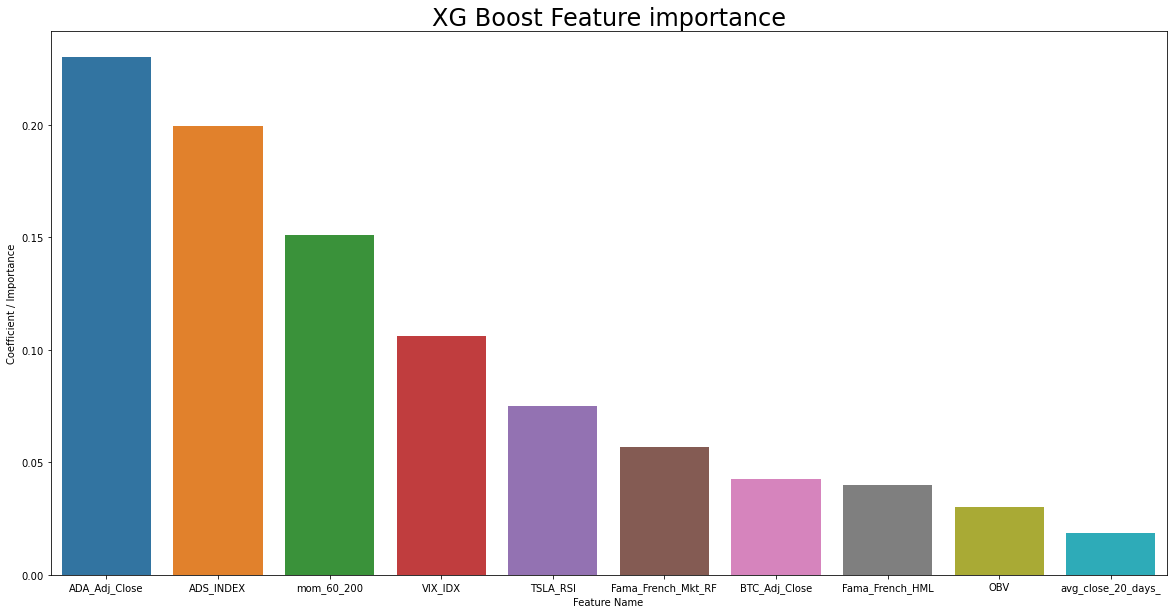

In [364]:
plot_features_with_importance("XG Boost Feature importance",selector_XGB,10)

In [365]:

def plot_features_with_importance_Regressions(title,selector,n=10):
    features_with_importance = sorted(list(zip(X.columns,selector.estimator.coef_)),key = lambda x: x[1],reverse=True)
    features_with_importance = features_with_importance[:n]
    for f_name,f_imp in features_with_importance[:3]:
        final_feature_set.add(f_name)
    df = pd.DataFrame(data={"Feature Name":[x[0] for x in features_with_importance],"Coefficient / Importance":[x[1] for x in features_with_importance]},columns=["Feature Name","Coefficient / Importance"])
    plt.figure(figsize = ( 20 , 10 ))
    sns.barplot(x=df['Feature Name'],y=df["Coefficient / Importance"]) 
    # Set title for figure
    plt.title( title , size = 24 )
    # Display figure
    plt.show()

In [366]:
def plot_features_with_importance_Random_forest(title,selector,n=10):
    features_with_importance = sorted(list(zip(X.columns,selector.estimator.feature_importances_)),key = lambda x: x[1],reverse=True)
    features_with_importance = features_with_importance[:n]
    for f_name,f_imp in features_with_importance[:3]:
        final_feature_set.add(f_name)
    df = pd.DataFrame(data={"Feature Name":[x[0] for x in features_with_importance],"Coefficient / Importance":[x[1] for x in features_with_importance]},columns=["Feature Name","Coefficient / Importance"])
    plt.figure(figsize = ( 20 , 10 ))
    sns.barplot(x=df['Feature Name'],y=df["Coefficient / Importance"]) 
    # Set title for figure
    plt.title( title , size = 24 )
    # Display figure
    plt.show()
    selector_RF.estimator.feature_importances_

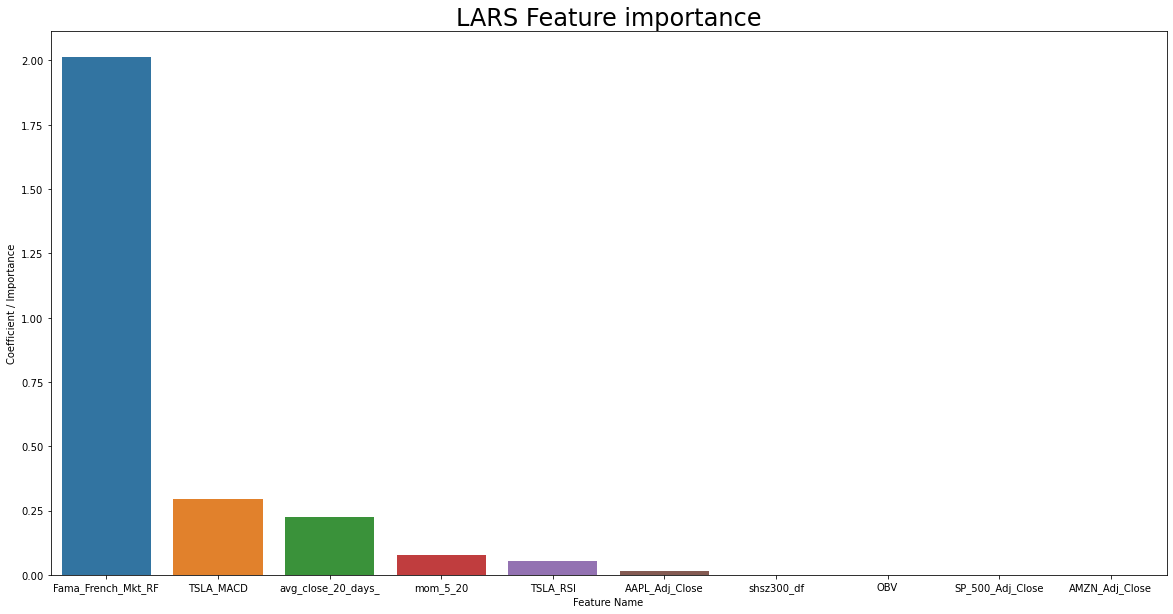

In [367]:
plot_features_with_importance_Regressions("LARS Feature importance",selector_LARS,10)


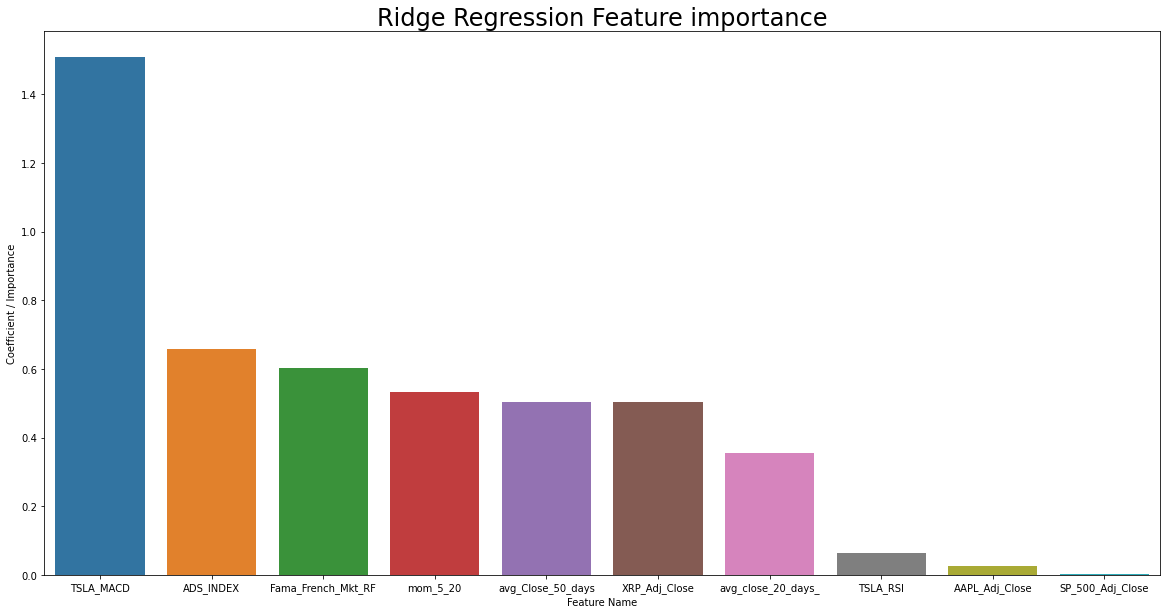

In [368]:
plot_features_with_importance_Regressions("Ridge Regression Feature importance",selector_RIDGE,10)


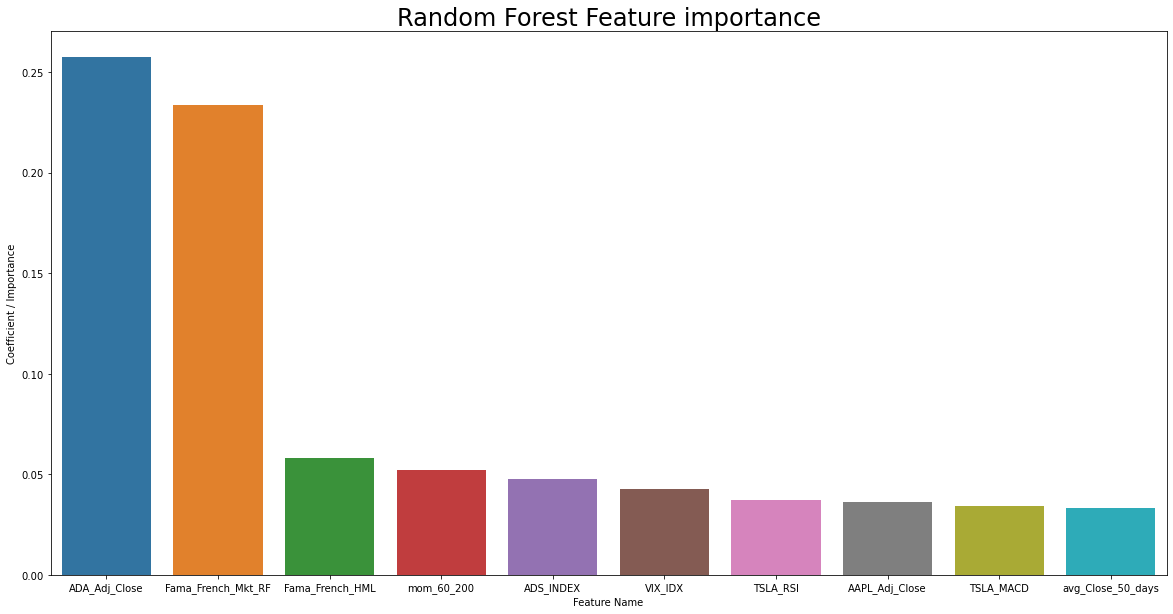

In [369]:
plot_features_with_importance_Random_forest("Random Forest Feature importance",selector_RF,10)


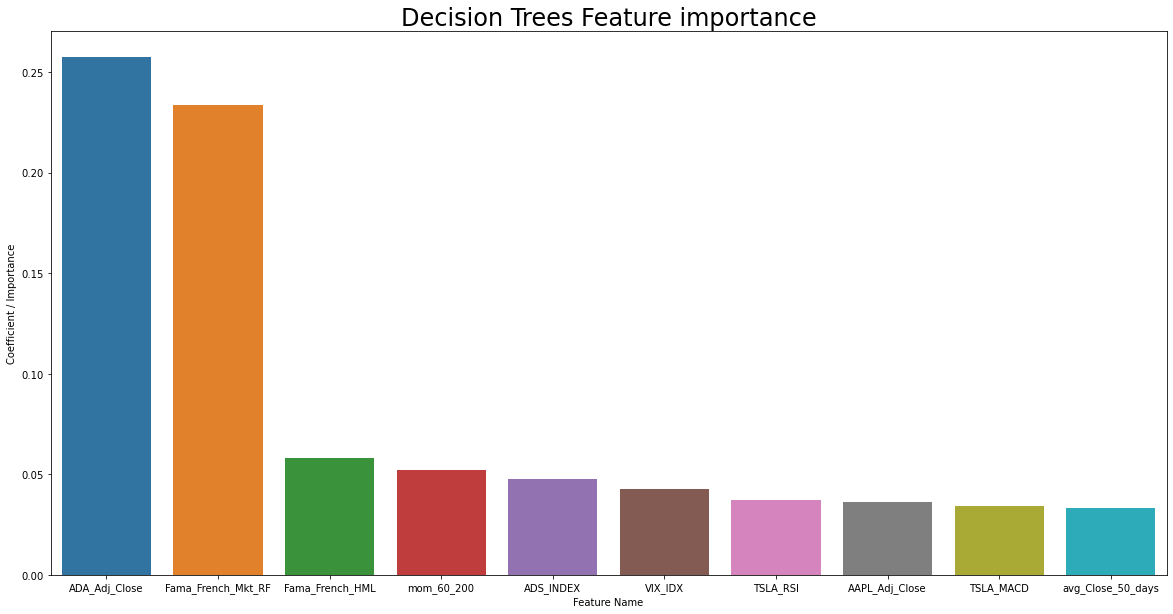

In [370]:
plot_features_with_importance_Random_forest("Decision Trees Feature importance",selector_RF,10)


In [371]:
print(final_feature_set)
print(len(final_feature_set))

{'avg_close_20_days_', 'Fama_French_Mkt_RF', 'mom_60_200', 'TSLA_MACD', 'ADS_INDEX', 'ADA_Adj_Close', 'Fama_French_HML'}
7
